# Improving from the original model
Removing the bias in test/val dataset

# Dependencies
For downloading dataset from kaggle

In [0]:
from google.colab import files

!pip install -q kaggle 

In [0]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


# Dataset preprocessing

In [0]:
! kaggle datasets download -d koryakinp/fingers

 97% 354M/363M [00:02<00:00, 134MB/s]
100% 363M/363M [00:02<00:00, 135MB/s]


In [0]:
!unzip -q fingers.zip -d .

In [0]:
import os, shutil

train_dir = '/content/train'
val_dir = '/content/validation'
test_dir = '/content/test'

if not os.path.isdir(val_dir):
  os.mkdir(val_dir)

a = [0 for i in range(6)]
ratio = 1/6
l = os.listdir(train_dir)

for fname in l:
  i = int(fname[-6])
  dir_train_i = os.path.join(train_dir, '{}'.format(i))
  dir_val_i = os.path.join(val_dir, '{}'.format(i))
  
  if not os.path.isdir(dir_train_i):
    os.mkdir(dir_train_i)
  if not os.path.isdir(dir_val_i):
    os.mkdir(dir_val_i)

  src = os.path.join(train_dir, fname)
  if(a[i] < int(3000*ratio)):
    shutil.move(src, dir_val_i)
  else:
    shutil.move(src, dir_train_i);

  a[i] += 1


In [0]:
for i in range(6):  
  print(len(os.listdir(os.path.join(val_dir, '{}'.format(i)))))

500
500
500
500
500
500


In [0]:
l = os.listdir(test_dir)

for fname in l:
  i = int(fname[-6])
  dir_test_i = os.path.join(test_dir, '{}'.format(i))

  if not os.path.isdir(dir_test_i):
    os.mkdir(dir_test_i)

  src = os.path.join(test_dir, fname)
  shutil.move(src, dir_test_i)

In [0]:
for i in range(6):  
  print(len(os.listdir(os.path.join(test_dir, '{}'.format(i)))))

600
600
600
600
600
600


In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=150,
                                                    target_size=(150,150),
                                                    class_mode='categorical')
val_generator = test_datagen.flow_from_directory(val_dir, 
                                                 batch_size=30,
                                                 target_size=(150, 150),
                                                 class_mode='categorical')

Found 15000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [27]:
x, y = train_generator[1]
x.shape, y.shape

((150, 150, 150, 3), (150, 6))

# Fitting pretrained model
Using data augmentation

In [28]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [29]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 15,764,166
Trainable params: 15,764,166
Non-trainable params: 0
_________________________________________________________________


In [30]:
from keras import optimizers

conv_base.trainable = False

model.compile(loss='categorical_crossentropy', 
             optimizer=optimizers.Adam(), 
             metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 15,764,166
Trainable params: 1,049,478
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
x, y = val_generator[1]
print(x.shape, y.shape)

(30, 150, 150, 3) (30, 6)


In [32]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch=100,
                             epochs=5,
                             validation_data=val_generator,
                             validation_steps=100)
# Fine-tuning not needed as the model gives good enough accuracy with data augmentation only 

Epoch 1/5
100/100 [==============================] - 105s 1s/step - loss: 0.3334 - acc: 0.9056 - val_loss: 0.0243 - val_acc: 0.9917
Epoch 2/5
100/100 [==============================] - 97s 974ms/step - loss: 0.0639 - acc: 0.9875 - val_loss: 0.0165 - val_acc: 0.9940
Epoch 3/5
100/100 [==============================] - 97s 965ms/step - loss: 0.0364 - acc: 0.9936 - val_loss: 0.0052 - val_acc: 0.9993
Epoch 4/5
100/100 [==============================] - 97s 975ms/step - loss: 0.0250 - acc: 0.9957 - val_loss: 0.0015 - val_acc: 0.9987
Epoch 5/5
100/100 [==============================] - 96s 958ms/step - loss: 0.0182 - acc: 0.9973 - val_loss: 0.0037 - val_acc: 0.9993


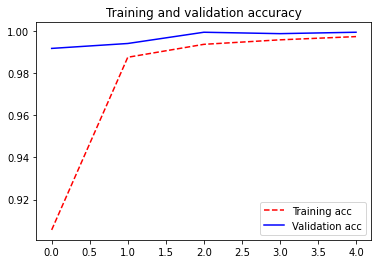

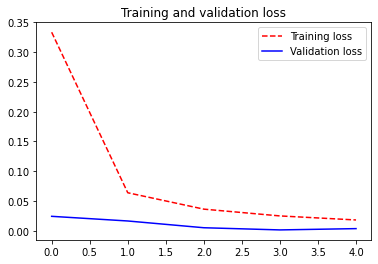

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation

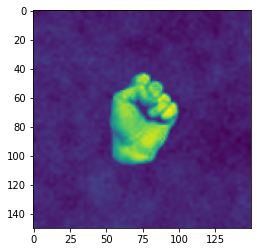

[[1.0000000e+00 8.5805509e-11 8.5249437e-25 0.0000000e+00 1.8429158e-34
  3.4880579e-35]]


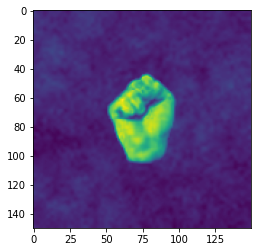

[[1. 0. 0. 0. 0. 0.]]


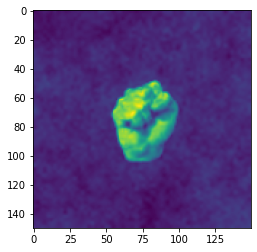

[[1.0000000e+00 2.4254481e-16 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]


In [34]:
# plt.imshow(x_test[234, :, :, 1])
# plt.show()
# a = 0
# for i in range(x_test.shape[0]):
#   result = model.predict(np.array([x_test[i]]))
#   if np.argmax(result) == y_test[i]:
#      a += 1 # prediction on validation data

# acc = a/(x_test.shape[0])
# acc

import cv2 as cv
import numpy as np

zeros = os.path.join(val_dir, '0')
l = os.listdir(zeros)
for name in l[0:3]:
  image = cv.imread(os.path.join(zeros, name))
  image = cv.resize(image, (150, 150))
  plt.imshow(image[:,:,1])
  plt.show()
  print(model.predict(np.array([image])))

In [35]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                 batch_size=30,
                                                 target_size=(150, 150),
                                                 class_mode='categorical')

loss, acc = model.evaluate_generator(test_generator, verbose=1)

Found 3600 images belonging to 6 classes.
120/120 [==============================] - 19s 155ms/step


In [36]:
print('loss:', loss)
print('acc:', acc)

loss: 0.0014457178767770529
acc: 0.9994444251060486


In [0]:
model.save('model_gesture_classification')